In [1]:
%reload_ext autoreload
%autoreload 1
%autosave 1

Autosaving every 1 seconds


In [2]:
import os
import pandas as pd
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import wandb
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.distributions
from torchvision.io import read_image
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from sklearn.metrics import classification_report

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.linear1 = nn.Linear(4500, 1024)
        self.linear2 = nn.Linear(1024, 512)
        self.linear3 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        return self.linear3(x)

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 1024)
        self.linear3 = nn.Linear(1024, 4500)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = F.relu(self.linear2(z))
        z = torch.sigmoid(self.linear3(z))
        return z.reshape((-1, 3, 30, 50))

class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [5]:
class ProlivDataset(Dataset):
    def __init__(self, img_dir, labels, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        # Load labels from a file or generate them from a list
        if isinstance(labels, str):
            # Assuming the labels file is a CSV for this example; adjust as needed
            self.labels = pd.read_csv(labels, sep=" ", names=["filename", "label"])
        else:
            self.labels = self._generate_labels(labels)

    def _generate_labels(self, labels):
        # Validate that there are as many labels as images
        filenames = os.listdir(self.img_dir)

        return pd.DataFrame({
            "filename": filenames,
            "label": labels
        })

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.labels.iloc[idx, 0])

        try:
            image = read_image(img_path)
        except Exception as e:
            raise RuntimeError(f"Error reading the image file {img_path}: {e}")

        label = self.labels.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

    def show(self, indexes):
        fig, axes = plt.subplots(len(indexes), len(indexes[0]), figsize=(10, 8))
        axes = axes.reshape(-1)  # Flatten the axes array for easy iteration

        for ax, idx in zip(axes, [idx for sublist in indexes for idx in sublist]):
            img_path = os.path.join(self.img_dir, self.labels.iloc[idx, 0])
            image = read_image(img_path).permute(1, 2, 0)  # Adjust for matplotlib

            # Apply inverse transformations if necessary to display the image correctly
            if self.transform:
                image = self._inverse_transform(image)

            label = self.labels.iloc[idx, 1]
            ax.imshow(image)
            ax.set_title(f"Label: {label}")
            ax.axis('off')

        plt.tight_layout()
        plt.show()

    def _inverse_transform(self, image):
        # Implement the inverse of your transformations here, if applicable.
        # This is necessary if your transformations significantly alter the image's appearance.
        # For example, normalizing pixel values would require an inverse normalization here.
        return image


In [6]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((30, 50)),
    transforms.ToTensor()
])

train_dataset = ProlivDataset(os.path.join(os.pardir, "dataset", "train"), 0, transform=transform)
proliv_dataset = ProlivDataset(os.path.join(os.pardir, "dataset", "proliv"), 1, transform=transform)

test_dataset_path = os.path.join(os.pardir, "dataset", "test")
test_labels = os.path.join(test_dataset_path, "test_annotation.txt")

test_dataset = ProlivDataset(os.path.join(os.pardir, "dataset", "test", "imgs"), test_labels, transform=transform)

batch_size = 128
latent_dims = 256
epochs = 500
lr = 1e-3
shuffle = True

# Create DataLoader
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)

autoencoder = Autoencoder(latent_dims=latent_dims).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=lr)

In [19]:
wandb.init(project='itmo-generative-models', entity='ildar-azamatov')

In [8]:
# Configure wandb to log hyperparameters and system stats
wandb.config = {
  "epochs": epochs,
  "batch_size": batch_size,
  "latent_dims": latent_dims,
}

In [10]:
# Adding wandb.watch to log gradients, parameters, and model topology
wandb.watch(autoencoder, log='all')

for epoch in range(wandb.config["epochs"]):
    running_loss = 0.0
    for images, _ in dataloader:
        images = images.to(device)

        # Forward pass
        outputs = autoencoder(images)
        loss = criterion(outputs, images)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss over an epoch
    epoch_loss = running_loss / len(dataloader)

    # Logging the metrics to wandb
    wandb.log({"epoch": epoch + 1, "loss": epoch_loss})

    print(f'Epoch [{epoch+1}/{wandb.config["epochs"]}], Loss: {epoch_loss:.10f}')

# wandb.finish()
print('Training completed')

Epoch [1/500], Loss: 0.0018321124
Epoch [2/500], Loss: 0.0015055920
Epoch [3/500], Loss: 0.0014719667
Epoch [4/500], Loss: 0.0013726093
Epoch [5/500], Loss: 0.0012743901
Epoch [6/500], Loss: 0.0013119371
Epoch [7/500], Loss: 0.0013204456
Epoch [8/500], Loss: 0.0011220930
Epoch [9/500], Loss: 0.0010072004
Epoch [10/500], Loss: 0.0009234271
Epoch [11/500], Loss: 0.0008767056
Epoch [12/500], Loss: 0.0008581980
Epoch [13/500], Loss: 0.0008343687
Epoch [14/500], Loss: 0.0008272557
Epoch [15/500], Loss: 0.0008874912
Epoch [16/500], Loss: 0.0008302789
Epoch [17/500], Loss: 0.0008298729
Epoch [18/500], Loss: 0.0008227737
Epoch [19/500], Loss: 0.0007981248
Epoch [20/500], Loss: 0.0008122353
Epoch [21/500], Loss: 0.0007811520
Epoch [22/500], Loss: 0.0007850927
Epoch [23/500], Loss: 0.0006991732
Epoch [24/500], Loss: 0.0006728812
Epoch [25/500], Loss: 0.0006524947
Epoch [26/500], Loss: 0.0006265760
Epoch [27/500], Loss: 0.0006156260
Epoch [28/500], Loss: 0.0005811591
Epoch [29/500], Loss: 0.00055

KeyboardInterrupt: 

In [11]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,245
loss,0.00018


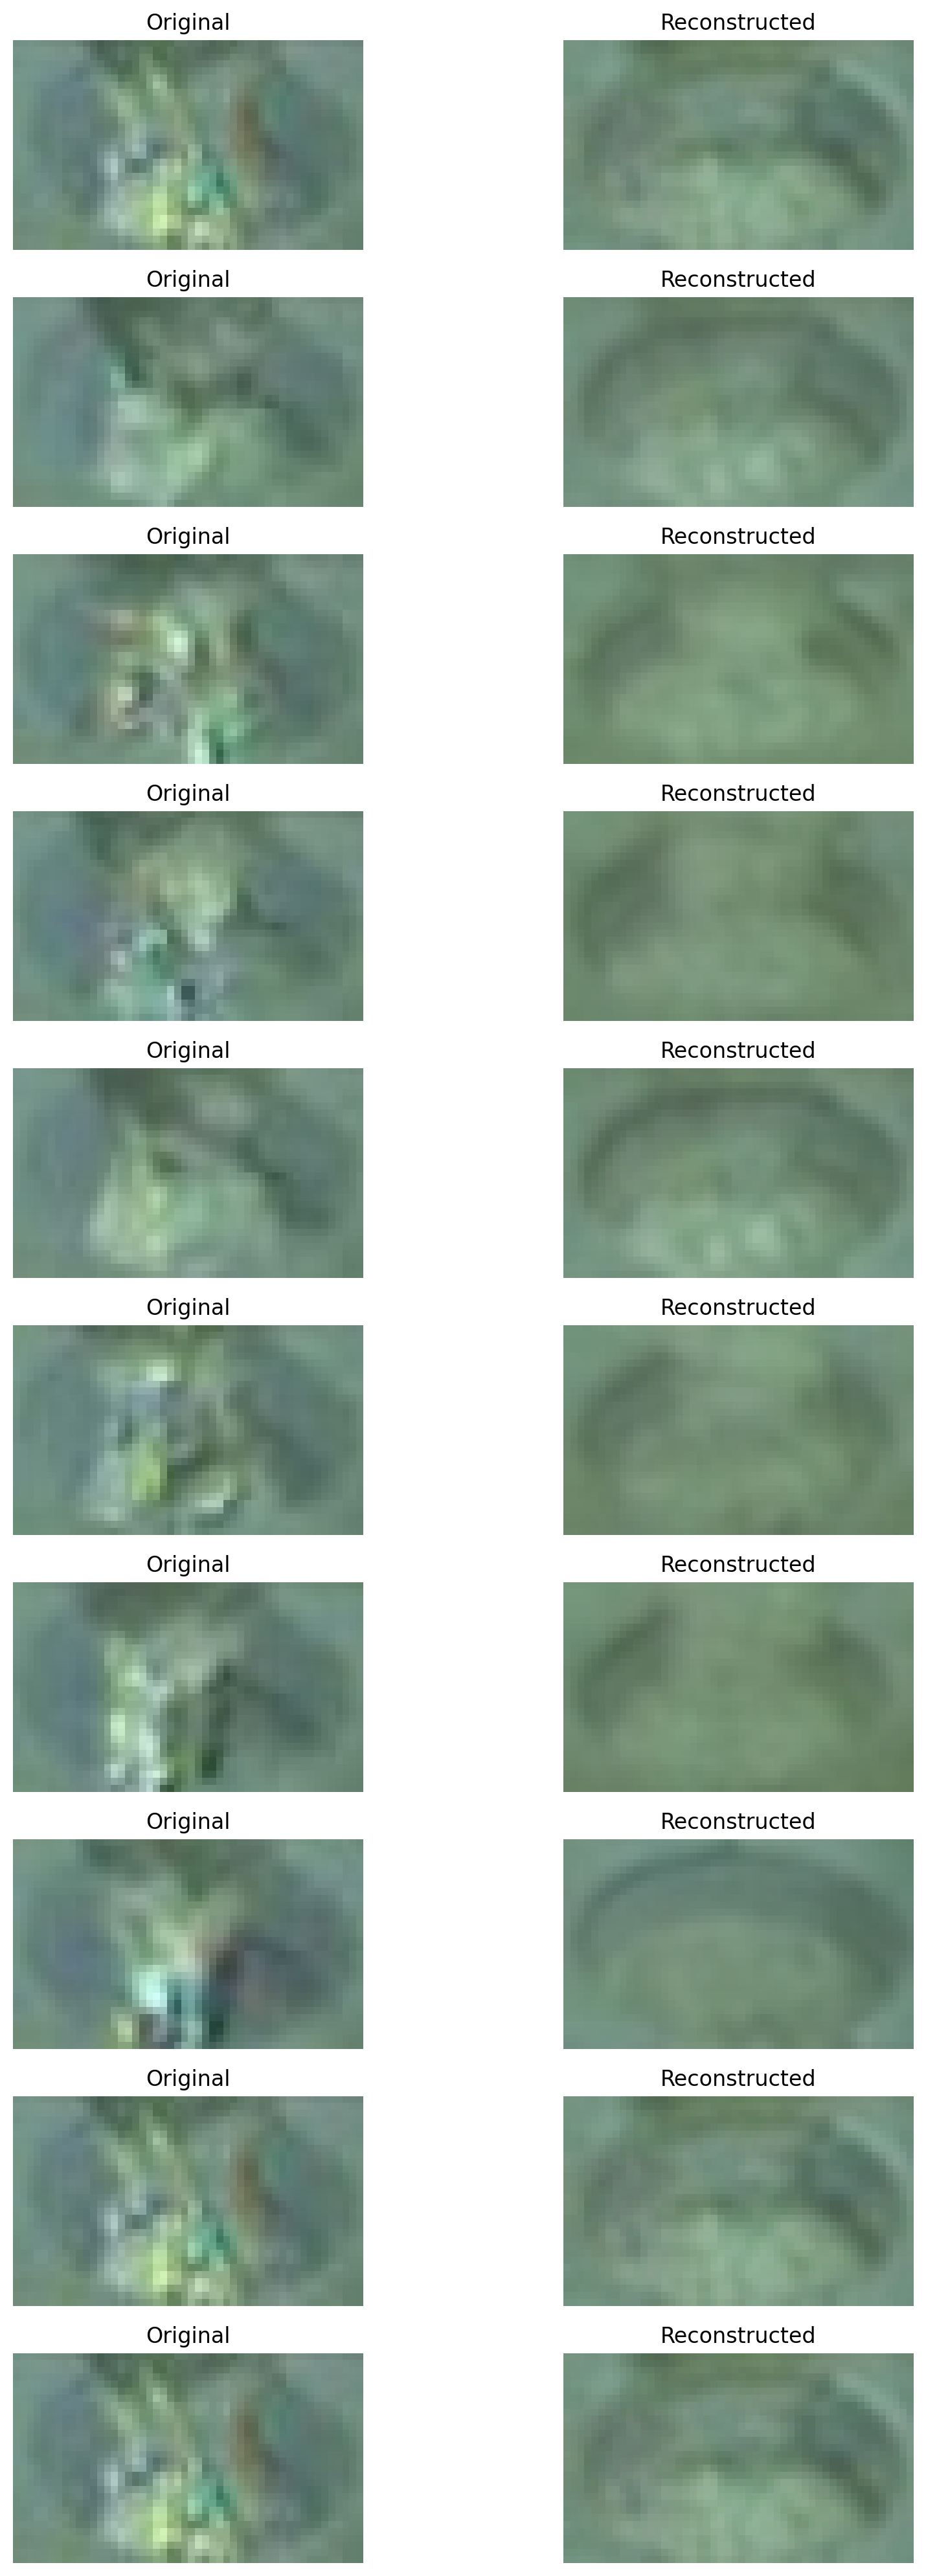

In [12]:
autoencoder.eval()  # Set the model to evaluation mode

# Function to perform inference and visualize results
def inference_and_visualize(dataset, autoencoder, device, num_samples=10):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 2 * num_samples))
    
    for i in range(num_samples):
        # Get a sample from the dataset
        x, _ = dataset[i]
        x = x.to(device)  # Move the tensor to the device
        
        # Add batch dimension and perform inference
        x_reconstructed = autoencoder(x.unsqueeze(0)).squeeze(0).cpu().detach()  # Move the tensor back to CPU for visualization
        
        # Display the original and reconstructed images
        ax = axes[i, 0]
        ax.imshow(x.cpu().permute(1, 2, 0))  # Convert from CxHxW to HxWxC for matplotlib and move tensor to CPU
        ax.set_title('Original')
        ax.axis('off')
        
        ax = axes[i, 1]
        ax.imshow(x_reconstructed.permute(1, 2, 0))  # Convert from CxHxW to HxWxC for matplotlib
        ax.set_title('Reconstructed')
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

# Run inference and visualize a few reconstructions
inference_and_visualize(proliv_dataset, autoencoder, device)

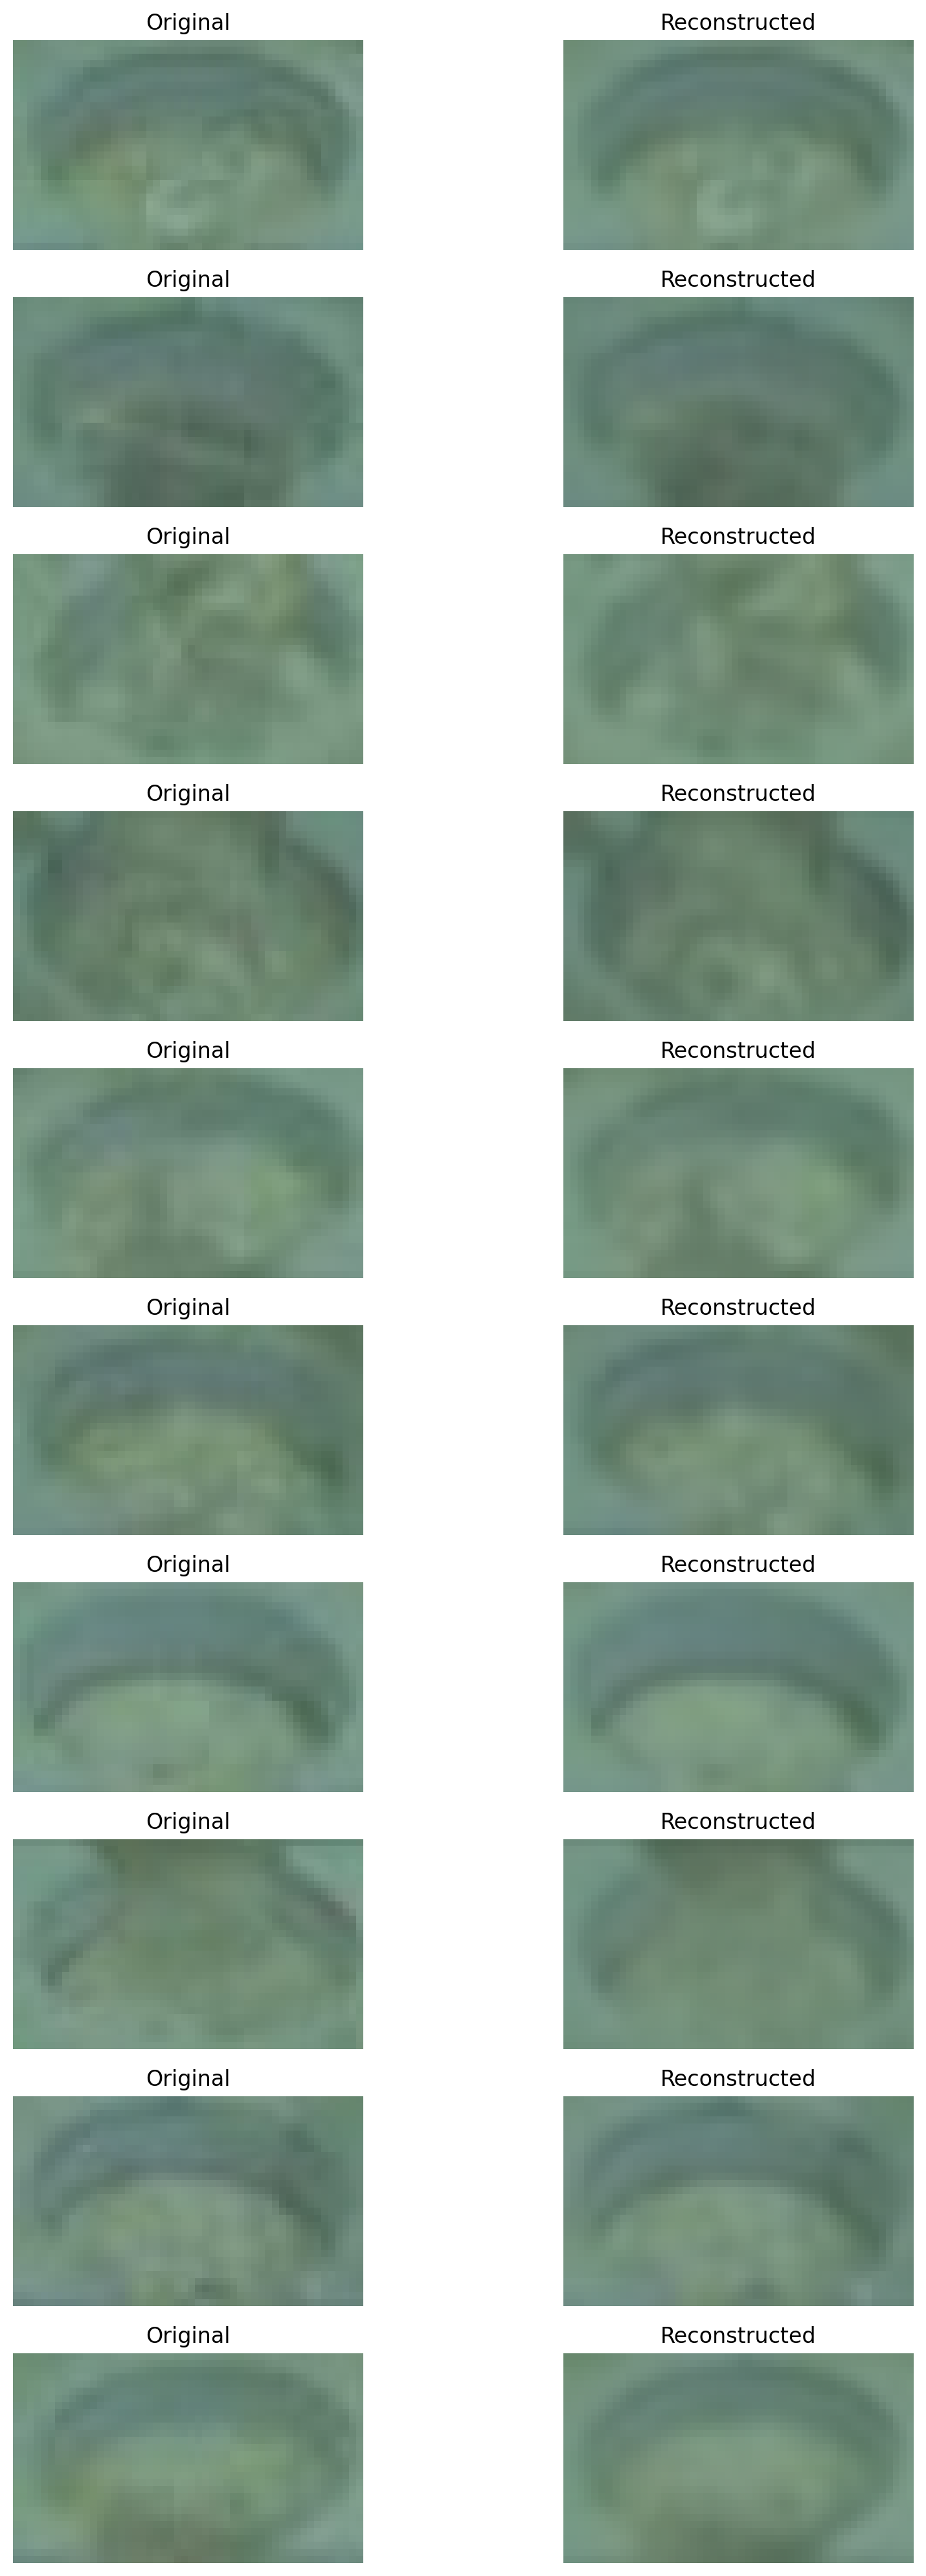

In [13]:
# Run inference and visualize a few reconstructions
inference_and_visualize(train_dataset, autoencoder, device)

In [14]:
def calculate_individual_losses(dataset, autoencoder, device):
    autoencoder.eval()  # Ensure the model is in evaluation mode
    losses = []  # List to store the MSE for each image

    with torch.no_grad():  # No need to keep track of gradients
        for i in range(len(dataset)):
            # Get a sample from the dataset
            x, _ = dataset[i]
            x = x.to(device)  # Move the tensor to the device

            # Add batch dimension and perform inference
            x_reconstructed = autoencoder(x.unsqueeze(0))

            # Calculate the loss between the original and the reconstructed image
            loss = F.mse_loss(x_reconstructed, x.unsqueeze(0))

            # Append the individual loss to the list
            losses.append(loss.item())

    return losses

In [20]:
wandb.unwatch()

In [21]:
train_losses = calculate_individual_losses(train_dataset, autoencoder, device)
proliv_losses = calculate_individual_losses(proliv_dataset, autoencoder, device)

In [22]:
from sklearn.metrics import roc_curve


def find_best_threshold(probabilities_pos, probabilities_neg):
    # Combine the probabilities into one array and the true labels into another array
    probabilities = np.concatenate([probabilities_pos, probabilities_neg])
    labels = np.concatenate([np.ones(len(probabilities_pos)), np.zeros(len(probabilities_neg))])
    
    # Calculate the False Positive Rate, True Positive Rate, and thresholds
    fpr, tpr, thresholds = roc_curve(labels, probabilities)
    
    # Calculate the distances to the top-left corner for each threshold
    distances = np.sqrt((1-tpr)**2 + fpr**2)
    
    # Find the index of the smallest distance
    min_distance_idx = np.argmin(distances)
    
    # The best threshold is the one with the smallest distance to the top-left corner
    best_threshold = thresholds[min_distance_idx]
    
    return best_threshold

In [23]:
best_threshold = find_best_threshold(proliv_losses, train_losses)

In [24]:
best_threshold

0.0015048830537125468

In [25]:
def calculate_labels(dataset, autoencoder, threshold, device):
    autoencoder.eval()  # Ensure the model is in evaluation mode
    labels = []  # List to store the MSE for each image

    with torch.no_grad():  # No need to keep track of gradients
        for i in range(len(dataset)):
            # Get a sample from the dataset
            x, _ = dataset[i]
            x = x.to(device)  # Move the tensor to the device

            # Add batch dimension and perform inference
            x_reconstructed = autoencoder(x.unsqueeze(0))

            # Calculate the loss between the original and the reconstructed image
            loss = F.mse_loss(x_reconstructed, x.unsqueeze(0))

            label = int(loss >= threshold)
            labels.append(label)

    return labels

In [31]:
pred = calculate_labels(test_dataset, autoencoder, best_threshold + 0.0005, device)

In [32]:
def calculate_tpr_tnr(true_labels, predicted_labels):
    """
    Calculate the True Positive Rate (TPR) and True Negative Rate (TNR).

    Parameters:
    - true_labels: array-like, true binary labels in range {0, 1} or {-1, 1}
    - predicted_labels: array-like, predicted binary labels in range {0, 1} or {-1, 1}

    Returns:
    - tpr: True Positive Rate
    - tnr: True Negative Rate
    """
    # Ensure inputs are numpy arrays for easy element-wise operations
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # True Positives (TP): We predicted positive, and it's true.
    TP = np.sum((predicted_labels == 1) & (true_labels == 1))

    # True Negatives (TN): We predicted negative, and it's true.
    TN = np.sum((predicted_labels == 0) & (true_labels == 0))

    # False Negatives (FN): We predicted negative, but it's false.
    FN = np.sum((predicted_labels == 0) & (true_labels == 1))

    # False Positives (FP): We predicted positive, but it's false.
    FP = np.sum((predicted_labels == 1) & (true_labels == 0))

    # True Positive Rate (TPR) = TP / (TP + FN)
    tpr = TP / (TP + FN) if (TP + FN) > 0 else 0

    # True Negative Rate (TNR) = TN / (TN + FP)
    tnr = TN / (TN + FP) if (TN + FP) > 0 else 0

    return tpr, tnr

In [33]:
calculate_tpr_tnr(test_dataset.labels["label"].values, pred)

(0.8914728682170543, 0.7557980900409277)

In [34]:
print(classification_report(test_dataset.labels["label"].values, pred))

              precision    recall  f1-score   support

           0       0.99      0.76      0.86      3665
           1       0.11      0.89      0.20       129

    accuracy                           0.76      3794
   macro avg       0.55      0.82      0.53      3794
weighted avg       0.97      0.76      0.84      3794

